# Reverse Engineering Badminton BC Membership Numbers

In an email newsletter, released on Monday, November 11, 2024, Badminton BC published a section about membership growth. Membership growth was provided in % change year over year, but the actual numbers were not provided. Additionally, overall % change was included between 2018-2024. The image has been provided below:

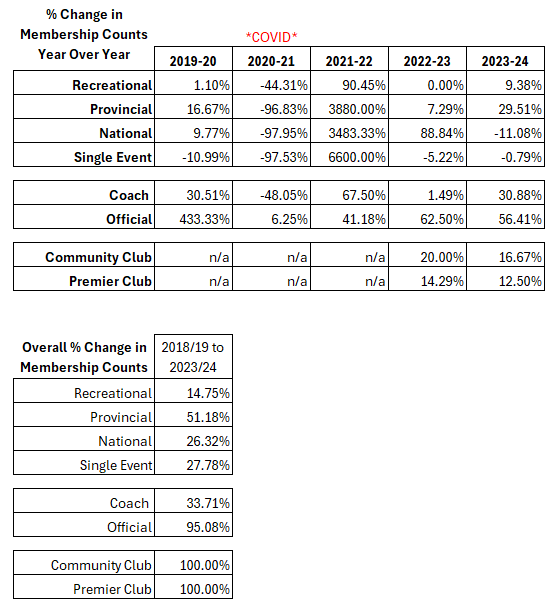

## Can we reverse engineer membership numbers from the data?

With year over year (YoY) increases for money, it would be almost impossible to determine, but with membership numbers, they have to be integers (because we cannot have fractions of people for obvious reasons).

Of course, there will be some rounding error, but as long as the number is close enough to an integer, we can let Python try different combinations until we find something!

In [1]:
# Define the percentage change data for each category
percentage_changes = {
    'Recreational': [1.10, -44.31, 90.45, 0.00, 9.38],
    'Provincial': [16.67, -96.83, 3880.00, 7.29, 29.51],
    'National': [9.77, -97.95, 3483.33, 88.84, -11.08],
    'Single Event': [-10.99, -97.53, 6600.00, -5.22, -0.79],
    'Coach': [30.51, -48.05, 67.50, 1.49, 30.88],
    'Official': [433.33, 6.25, 41.18, 62.50, 56.41]
}

# Convert percentage changes to multipliers (e.g. 1.10% becomes 1.011)
multipliers = (
    {k: [(1 + pct / 100) for pct in v] for k, v in percentage_changes.items()}
)

# Adjust range based on expected membership size
initial_count_range = range(1, 3000)

# Store results
results = {}

# Find a reasonable base count for each category matching the pattern of change
for category, factors in multipliers.items():
    for base_count in initial_count_range:
        counts = [base_count]
        valid = True

        # Calculate counts for each subsequent year based on multipliers
        for factor in factors:
            new_count = counts[-1] * factor
            # Check if the result is within +/- range of an integer
            error = 0.03 # Adjust error amount
            if abs(new_count - round(new_count)) <= error:
                counts.append(int(round(new_count)))
            else:
                valid = False
                break

        # If we found a valid sequence of counts, save it
        if valid:
            results[category] = counts
            break

# Display the results
for category, counts in results.items():
    print(f'{category}: Estimated counts = {counts}')

Recreational: Estimated counts = [1730, 1749, 974, 1855, 1855, 2029]
Provincial: Estimated counts = [270, 315, 10, 398, 427, 553]
National: Estimated counts = [266, 292, 6, 215, 406, 361]
Single Event: Estimated counts = [91, 81, 2, 134, 127, 126]
Coach: Estimated counts = [59, 77, 40, 67, 68, 89]
Official: Estimated counts = [3, 16, 17, 24, 39, 61]


#### Let's Display it as a DataFrame

In [2]:
import numpy as np
import pandas as pd

# Create a DataFrame from the results dictionary and set the index to the categories
df = pd.DataFrame.from_dict(results, orient='index', columns=[
    '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24'
])

# Display DataFrame
df

,2018-19,2019-20,2020-21,2021-22,2022-23,2023-24
Recreational,1730,1749,974,1855,1855,2029
Provincial,270,315,10,398,427,553
National,266,292,6,215,406,361
Single Event,91,81,2,134,127,126
Coach,59,77,40,67,68,89
Official,3,16,17,24,39,61


Let's take the YoY % changes from our data and see if the percentages match:

In [3]:
# Calculate Year-over-Year percentage changes
yoy_changes = np.round(df.pct_change(axis='columns') * 100, 2)

# Rename columns for clarity in the YOY changes DataFrame
yoy_changes.columns = [
    '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24'
]

# Remove first column on NaNs
yoy_change_df = yoy_changes.iloc[:, -5:]

# View dataframe
yoy_change_df

,2019-20,2020-21,2021-22,2022-23,2023-24
Recreational,1.10,-44.31,90.45,0.00,9.38
Provincial,16.67,-96.83,3880.00,7.29,29.51
National,9.77,-97.95,3483.33,88.84,-11.08
Single Event,-10.99,-97.53,6600.00,-5.22,-0.79
Coach,30.51,-48.05,67.50,1.49,30.88
Official,433.33,6.25,41.18,62.50,56.41


Okay! I think the numbers match to two decimal places.

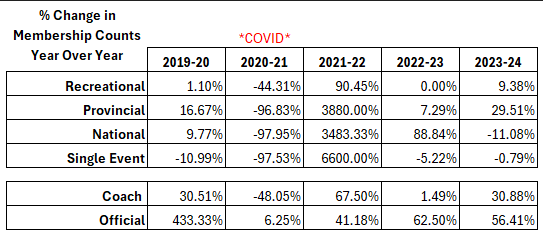

## Let's look at Overall % Change in Membership Counts from 2018-2024
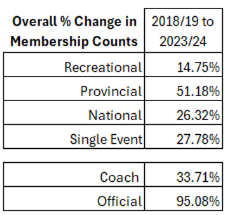

In [4]:
# Calculate the % change from 2018-19 to 2023-24 for each category
df['% Change 2018-2024'] = (
    # (Last Year - First Year) / First Year]
    np.round(((df['2023-24'] - df['2018-19']) / df['2018-19']) * 100, 2)
)

# Calculate the percent difference between 2018-2024 for each category
df['% Difference 2018-2024'] = (
    # 1 - (First Year / Last Year)
    np.round((1 - (df['2018-19'] / df['2023-24'])) * 100, 2)
)

# Display the new columns
df[['% Change 2018-2024', '% Difference 2018-2024']]

,% Change 2018-2024,% Difference 2018-2024
Recreational,17.28,14.74
Provincial,104.81,51.18
National,35.71,26.32
Single Event,38.46,27.78
Coach,50.85,33.71
Official,1933.33,95.08


# The Overall % Change is inaccurate

It appears that the percentage difference was calculated, instead of the percent change. The percent difference between the first year and last year understate the membership growth, but only considering the relative percentage change can be misleading as well.

Consider the % change for officials. A 1933.33% increase is often seen as fantastic, but generally, these increases only happen if your initial number was really small. This tactic is commonly used by media in reporting numbers from medical research. A 2000% increase is often terrible, but at the same time, the original number is likely very small, which is a small absolute change.

For example, if your risk of something is very small (i.e., 0.01%), a 2000% increase (2000% = 20x) would still be a 0.2% risk.

# Math Formulas

This is for my own reference too, because it can get confusing! Assuming that x is less than y (i.e. x < y):

### Overall % Change Formula

$$
\begin{align*}
\text{Overall \% Change} &= \left( \frac{\text{Year } y}{\text{Year } x} - 1 \right) \times 100 \\
&= \left( \frac{\text{Year } y - \text{Year } x}{\text{Year } x} \right) \times 100
\end{align*}
$$

### Percent Difference Formula

$$
\text{Percent Difference} = \left(1 - \frac{\text{Year } y}{\text{Year } x}  \right) \times 100
$$

# Additional Comments
This is still an estimate, and it is possible that true values could be a multiple of these set of numbers (although quite unlikely). For example, when looking at only two data points for club memberships, we would have an estimate of 5, 6, 7 for Community Clubs, and 7, 8, 9 for Premier Clubs. Without more data, it is difficult to know the true values. It is highly unlikely that there are more Premier Clubs than Community Clubs, so the true values for Community Clubs is likely (10, 12, 14), (15, 18, 21), or more (but not TOO much more).

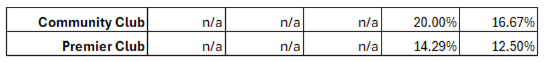

This is how I stumbled upon the Overall % Change error, because it shows an increase of 100% for both Community and Premier Clubs.

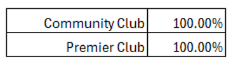

The only way to have a 100% percentage difference is if your inital value is 0.

# What are the true membership numbers?

This is extremely difficult to say, because the first question to ask is whether a member can hold 2 different memberships. The answer is **YES** because I have had both player and coach memberships in the past. Additionally, a national membership is only possible after getting a provincial one, so it should be impossible to have more national members than provincial members.

Other changes have been made behind the scenes which may better explain the changes in membership categories. Here are some examples:


*   Coach and officials memberships used to be combined as an "Associate" membership
*   Coaching courses were recently changed to require a coach membership for participation. Previously, recreational memberships were allowed to enroll in coach development courses. Once again, this indicates a double membership requirement for different categories.

This is particularly import to understand due to voting rights. Does each unique member get a single vote (generally assumed), or do they get multiple votes if they have additional memberships?

If a percentage of votes are needed by the membership in special circumstances, then what is the true membership number needed? For example, if 10% of membership is needed for a member requisition, is it 10% of all unique members, or is it of all memberships?

Because if it is all memberships, and some members hold multiple memberships, then do they get additional votes?

